# Import libraries and set random seed

In [1]:
import sys
import copy
import time

import numpy as np
import torch
import matplotlib.pyplot as plt

sys.path.insert(0, '..')
from graph_deep_decoder import datasets as ds
from graph_deep_decoder.architecture import GraphDecoder
from graph_deep_decoder.model import Model
from graph_deep_decoder import utils

SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

# Creating random SBM graph

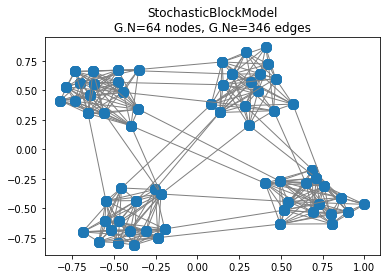

In [2]:
Gs = {}
Gs['type'] = ds.SBM
Gs['N'] = 64  # 256  # 64
Gs['k'] = 4
Gs['type_z'] = ds.CONT

if Gs['N'] >= 256:
    Gs['p'] = 0.25
    Gs['q'] = 0.1*Gs['k']/Gs['N'] # 0.003
else:
    Gs['p'] = 0.7
    Gs['q'] = 0.015  # 0.004  # 0.015

    #Gs['q'] = [[0, 0.0075, 0, 0.0],
#           [0.0075, 0, 0.004, 0.0025],
#           [0, 0.004, 0, 0.005],
#           [0, 0.0025, 0.005, 0]]

G = ds.create_graph(Gs, SEED)

A = G.W.todense()
L = G.L.todense()
G.plot()

# Create graph filters 

In [3]:
K = 3
#hs = [0.4, 0.4, 0.1, 0.05, 0.05]
hs = np.random.rand(K)
hs /= np.sum(hs)
print('Filter coeefs:', hs)
x_dw = ds.DiffusedWhiteGS(G, ds.NonLin.NONE, K, coefs=hs)
x_dw.to_unit_norm()
H = x_dw.H


Filter coeefs: [0.29399155 0.38311672 0.32289173]


# Analyze Jacobian

In [4]:
fts = 150  # 300  # 600
dec = GraphDecoder(fts, H)
dec_copy = copy.deepcopy(dec)
model = Model(dec_copy, epochs=1)
model.fit(x_dw.x)

JJ_an = dec.analytical_squared_jacobian()
JJ_aut = model.arch.autograd_squared_jacobian()

t1 = time.time()
Sigmas_an, U_an = utils.ordered_eig(JJ_an)
Sigmas_aut, U_aut = utils.ordered_eig(JJ_aut)
print('Time for computing eig:', time.time()-t1)

Time for computing eig: 0.002991914749145508


## Autograd Jacobian eigenvectors/eigenvalues

Text(0.5,1,'Eigvalues JJ^T')

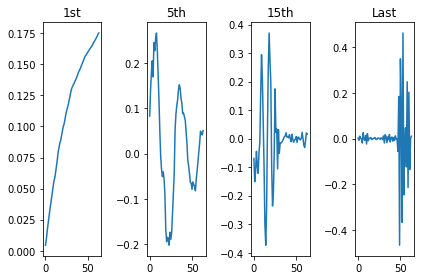

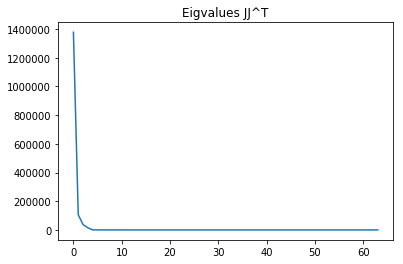

In [5]:
# Autogradient Jacobians eigendecomposition
plt.figure()
plt.subplot(141)
plt.plot(U_aut[:,0])
plt.title('1st')
plt.subplot(142)
plt.plot(U_aut[:,4])
plt.title('5th')
plt.subplot(143)
plt.plot(U_aut[:,14])
plt.title('15th')
plt.subplot(144)
plt.plot(U_aut[:,-1])
plt.title('Last')
plt.tight_layout()

plt.figure()
plt.plot(Sigmas_aut)
plt.title('Eigvalues JJ^T')

## Analytical Jacobian eigenvectors/eigenvalues

Text(0.5,1,'Eigvalues JJ^T')

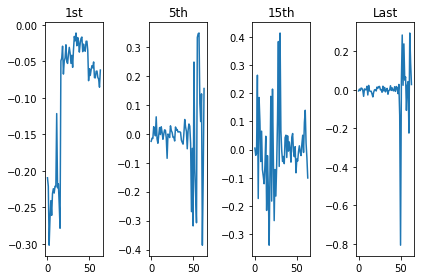

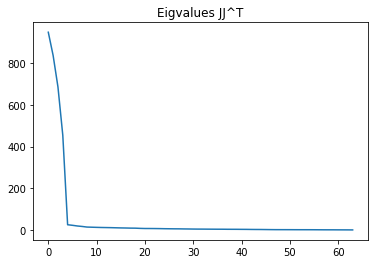

In [6]:
# Analytical Jacobians eigendecomposition
plt.figure()
plt.subplot(141)
plt.plot(U_an[:,0])
plt.title('1st')
plt.subplot(142)
plt.plot(U_an[:,4])
plt.title('5th')
plt.subplot(143)
plt.plot(U_an[:,14])
plt.title('15th')
plt.subplot(144)
plt.plot(U_an[:,-1])
plt.title('Last')
plt.tight_layout()

plt.figure()
plt.plot(Sigmas_an)
plt.title('Eigvalues JJ^T')


## Smoothness on L

Eigv 1: Smoothness over L: 0.5969316634217054
Eigv 2: Smoothness over L: 0.7988277231869158
Eigv 5: Smoothness over L: 15.317638514673986
Eigv 15: Smoothness over L: 12.825956360179703
Eigv last: Smoothness over L: 10.711966483249702


Text(0.5,0,'Eigenvectors')

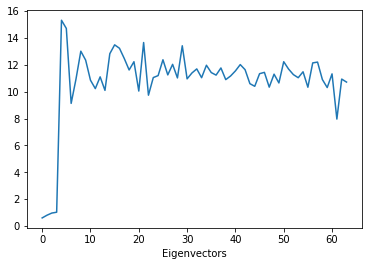

In [7]:
smoothness = np.diag(U_an.T.dot(L).dot(U_an))
print('Eigv 1: Smoothness over L:', smoothness[0])
print('Eigv 2: Smoothness over L:', smoothness[1])
print('Eigv 5: Smoothness over L:', smoothness[4])
print('Eigv 15: Smoothness over L:', smoothness[14])
print('Eigv last: Smoothness over L:', smoothness[-1])

plt.figure()
plt.plot(smoothness)
plt.xlabel('Eigenvectors')

## Compare with eigendecomposition of A

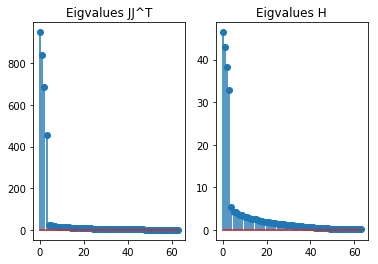

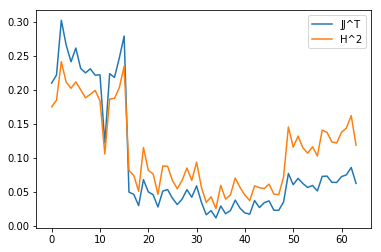

In [8]:
eigval_H, V_H = utils.ordered_eig(H)

U_an = utils.choose_eig_sign(U_an, V_H)

plt.subplot(121)
plt.stem(Sigmas_an)
plt.title('Eigvalues JJ^T')
plt.subplot(122)
plt.stem(eigval_H)
plt.title('Eigvalues H')

plt.figure()
plt.plot(U_an[:,0])
plt.plot(V_H[:,0])
plt.legend(['JJ^T','H^2'])

## Expected Squared Jacobian

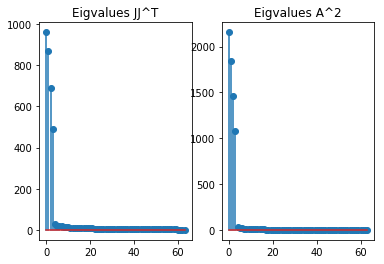

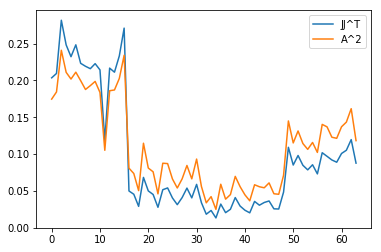

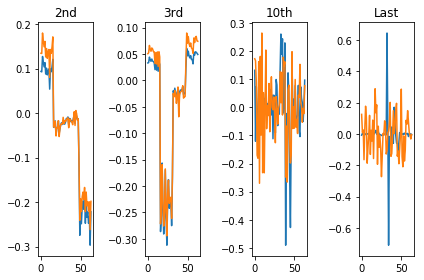

In [9]:
samples = 10000
Exp_JJ = np.zeros((G.N, G.N))
for i in range(samples):
    Exp_JJ += GraphDecoder(fts, H).analytical_squared_jacobian()/samples

Exp_S, Exp_U = utils.ordered_eig(Exp_JJ)
Exp_U = utils.choose_eig_sign(Exp_U, V_H)

plt.subplot(121)
plt.stem(Exp_S)
plt.title('Eigvalues JJ^T')
plt.subplot(122)
plt.stem(eigval_H**2)
plt.title('Eigvalues A^2')

plt.figure()
plt.plot(Exp_U[:, 0])
plt.plot(V_H[:, 0])
plt.legend(['JJ^T','A^2'])

plt.figure()
plt.subplot(141)
plt.plot(Exp_U[:, 1])
plt.plot(V_H[:,1])
plt.title('2nd')
plt.subplot(142)
plt.plot(Exp_U[:, 2])
plt.plot(V_H[:,2])
plt.title('3rd')
plt.subplot(143)
plt.plot(Exp_U[:, 9])
plt.plot(V_H[:,9])
plt.title('10th')
plt.subplot(144)
plt.plot(Exp_U[:, -1])
plt.plot(V_H[:, -1])
plt.title('Last')
plt.tight_layout()

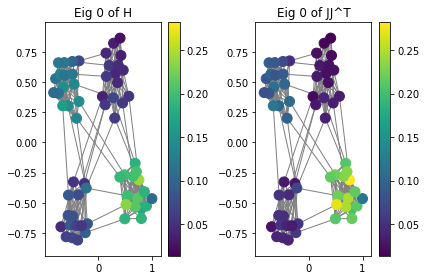

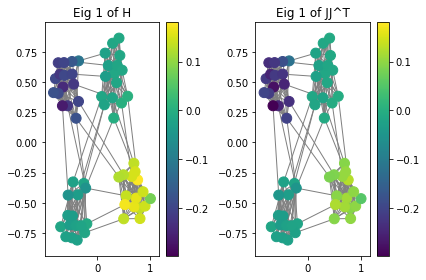

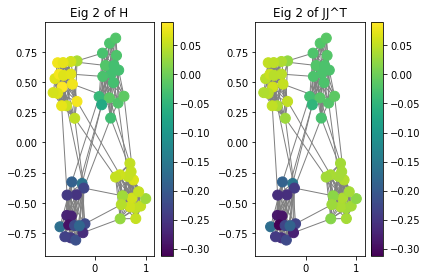

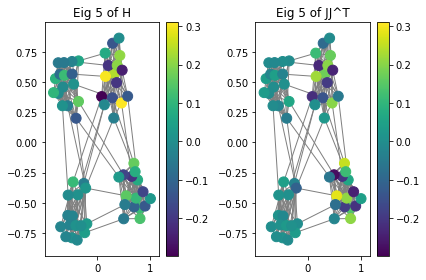

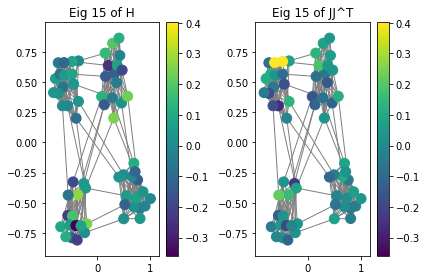

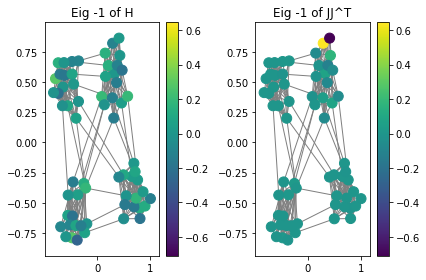

In [10]:
eig_inds = [0, 1, 2, 5, 15, -1]
for eig_ind in eig_inds:
    eig_H = V_H[:, eig_ind]
    eig_JJ = Exp_U[:, eig_ind]
    
    lims = [np.min([eig_H, eig_JJ]), np.max([eig_H, eig_JJ])]
    # lims = [-np.inf, np.inf]
    
    plt.figure()
    ax = plt.subplot(121)
    G.plot_signal(eig_H, ax=ax, limits=lims)
    plt.title('Eig {} of H'.format(eig_ind))
    ax = plt.subplot(122)
    G.plot_signal(eig_JJ, ax=ax, limits=lims)
    plt.title('Eig {} of JJ^T'.format(eig_ind))
    plt.tight_layout()


## Inner product of Jaconbian and A eigenvectors

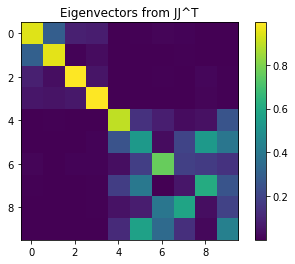

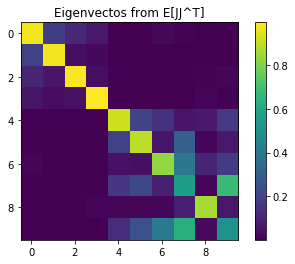

In [11]:
k = 10
V_H_k = V_H[:,:k]
U_an_k = U_an[:,:k]
U_exp_k = Exp_U[:,:k]

plt.figure()
plt.imshow(abs(V_H_k.T.dot(U_an_k)))
plt.title('Eigenvectors from JJ^T')
plt.colorbar()
plt.figure()
plt.imshow(abs(V_H_k.T.dot(U_exp_k)))
plt.title('Eigenvectos from E[JJ^T]')
plt.colorbar()


## Diagonalizing A

Error: 0.23053421965515888
Exp error: 0.009845995479227113


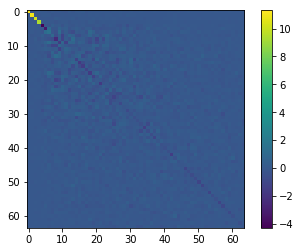

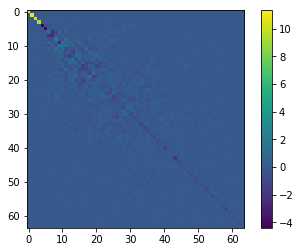

In [12]:
Diag = U_an.T.dot(A).dot(U_an)
Exp_diag = Exp_U.T.dot(A).dot(Exp_U)

print('Error:', (np.sum(np.diag(np.diag(Diag))-Diag)**2)/np.linalg.norm(A)**2)
print('Exp error:', (np.sum(np.diag(np.diag(Exp_diag))-Exp_diag)**2)/np.linalg.norm(A)**2)

plt.figure()
plt.imshow(Diag)
plt.colorbar()
plt.figure()
plt.imshow(Exp_diag)
plt.colorbar()

# Denoise signals

In [13]:
n_signals = 50
n_p = 0.1
epochs = 1000
lr = 0.001
dec = GraphDecoder(150, H, scale_std=.01)

err = np.zeros((3, epochs, n_signals))
for i in range(n_signals):
    # Create signals
    x = G.info['node_com']/np.linalg.norm(G.info['node_com'])
    noise = np.random.randn(x.size)*np.sqrt(n_p/x.size)
    x_n = x + noise
    noise /= np.linalg.norm(noise)

    # Create models
    model_x = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
    model_noise = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)
    model_x_n = Model(copy.deepcopy(dec), epochs=epochs, learning_rate=lr)

    # Train modesls
    _, err[0, :, i], _ = model_x.fit(x, x, reduce_err=True)
    _, err[1, :, i], _ = model_noise.fit(noise, noise, reduce_err=True)
    _, err[2, :, i], _ = model_x_n.fit(x_n, x, reduce_err=True)

    # Normalize error
    # err[0, :] = err[0, :]/np.linalg.norm(x)
    # err[1, :] = err[1, :]/np.linalg.norm(noise)
    # err[2, :] = err[2, :]/np.linalg.norm(x)
    print('Signal', i, 'done')

Signal 0 done
Signal 1 done
Signal 2 done
Signal 3 done
Signal 4 done
Signal 5 done
Signal 6 done
Signal 7 done
Signal 8 done
Signal 9 done
Signal 10 done
Signal 11 done
Signal 12 done
Signal 13 done
Signal 14 done
Signal 15 done
Signal 16 done
Signal 17 done
Signal 18 done
Signal 19 done
Signal 20 done
Signal 21 done
Signal 22 done
Signal 23 done
Signal 24 done
Signal 25 done
Signal 26 done
Signal 27 done
Signal 28 done
Signal 29 done
Signal 30 done
Signal 31 done
Signal 32 done
Signal 33 done
Signal 34 done
Signal 35 done
Signal 36 done
Signal 37 done
Signal 38 done
Signal 39 done
Signal 40 done
Signal 41 done
Signal 42 done
Signal 43 done
Signal 44 done
Signal 45 done
Signal 46 done
Signal 47 done
Signal 48 done
Signal 49 done


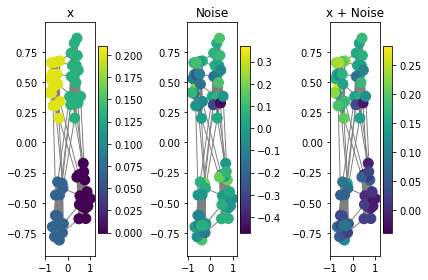

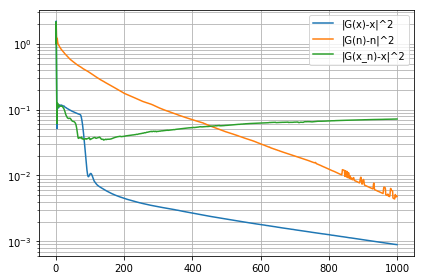

In [16]:
# Plot signals
plt.figure()
ax = plt.subplot(131)
G.plot_signal(x, ax=ax)
plt.title('x')
ax = plt.subplot(132)
G.plot_signal(noise, ax=ax)
plt.title('Noise')
ax = plt.subplot(133)
G.plot_signal(x_n, ax=ax)
plt.title('x + Noise')
plt.tight_layout()


# Plot error
err_med = np.median(err, axis=2)
plt.figure()
plt.semilogy(err_med.T)
plt.legend(['|G(x)-x|^2', '|G(n)-n|^2', '|G(x_n)-x|^2'])
plt.grid(True, which='both')
plt.tight_layout()

## Creating signals

In [15]:
plt.show()